# Portfolio 7
## The Path Following Method

We follow the construction followed in Vanderbei (2020) ch.18 and the lecture of March 25 to implement the path following method for linear programming problems.

## Problem Statement

The general linear programming problem as follows:
\begin{align*}
\text{maximize } c^Tx\\
\text{subject to } Ax \le b\\
x \ge 0
\end{align*}
where:
* x is a vector of decision variables;
* c is a vector of linear cost coefficients
* A is a matrix of constraints
* b is a vector of constants

## Summary of Previous Work

In the notebook from March 25, we used the logarithmic barrier problem to approximate the solution to this problem, and then used Newton's method to approximate the solution to the nonlinear barrier problem.
After applying the logarithmic barrier function and solving for its optimal points, the problem is redefined as:
\begin{align*}
A \mathbf{x} + \mathbf{w} &= \mathbf{b} \\
A^T \mathbf{y} - \mathbf{z} &= \mathbf{c} \\
XZ \mathbf{e} &= \mu \mathbf{e} \\
YW \mathbf{e} &= \mu \mathbf{e}
\end{align*}

$$
X = \begin{bmatrix} x_0 & & \\ & \ddots & \\ & & x_{n-1} \end{bmatrix}
\hspace{10mm}
W = \begin{bmatrix} w_0 & & \\ & \ddots & \\ & & w_{m-1} \end{bmatrix}
$$
$$
Y = \begin{bmatrix} y_0 & & \\ & \ddots & \\ & & y_{m-1} \end{bmatrix}
\hspace{10mm}
Z = \begin{bmatrix} z_0 & & \\ & \ddots & \\ & & z_{n-1} \end{bmatrix}
\hspace{10mm}
\mathbf{e} = \begin{bmatrix} 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix}
$$
where **x,z** are vectors of length n and **w,y** are vectors of length m.

To use Newton's Method, we defined 
$$
F(\boldsymbol{\xi}) = F(\mathbf{x},\mathbf{w}, \mathbf{y}, \mathbf{z})
=
\begin{bmatrix}
A \mathbf{x} + \mathbf{w} - \mathbf{b} \\
A^T \mathbf{y} - \mathbf{z} - \mathbf{c}\\
XZ \mathbf{e} - \mu \mathbf{e} \\
YW \mathbf{e} - \mu \mathbf{e}
\end{bmatrix}
$$
We use Newton's Method to approximate the zeros of this function:
$$
F(\boldsymbol{\xi} + \Delta \boldsymbol{\xi}) \approx F(\boldsymbol{\xi}) + F'(\boldsymbol{\xi}) \Delta \boldsymbol{\xi}
\Rightarrow
F(\boldsymbol{\xi}) = - F'(\boldsymbol{\xi}) \Delta \boldsymbol{\xi}
$$
This leads to the matrix equation
$$
\begin{bmatrix}
A \mathbf{x} + \mathbf{w} - \mathbf{b} \\
A^T \mathbf{y} - \mathbf{z} - \mathbf{c}\\
XZ \mathbf{e} - \mu \mathbf{e} \\
YW \mathbf{e} - \mu \mathbf{e}
\end{bmatrix}
=
-
\begin{bmatrix}
A & I & 0 & 0 \\
0 & 0 & A^T & -I \\
Z & 0 & 0 & X \\
0 & Y & W & 0
\end{bmatrix}
\begin{bmatrix}
\Delta \mathbf{x} \\ \Delta \mathbf{w} \\ \Delta \mathbf{y} \\ \Delta \mathbf{z}
\end{bmatrix}
$$

## Choosing Parameters

We continue here from the end of the March 25 notebook. Below is a paraphrase of Vanderbei sections 18.3 and 18.4.

### Barrier Parameter
At each step, we update the value for $\mu$.
We must choose a value that sets the sequence onto the path towards the optimal point.
However, we are likely to be at a point $(x,w,y,z)$ that is not on the optimal path.
Since we have the equations $XZe = \mu e$ and $YWe = \mu e$, computing $z_jx_j$ for fixed j, or $w_iy_i$ for fixed i, allows us to estimate $\mu$. To get a better estimate, we take the average of all these values, $\frac{z^Tx + y^Tw}{n+m}$.
In order to move towards the optimal solution, we want $\mu$ to decay towards 0 as we iterate, so we want some fraction of this value.
Thus, we set an additional parameter $\delta \in (0,1)$ and take 
$$
\mu = \delta \frac{z^Tx + y^Tw}{n+m}
$$
Vanderbei suggests $\delta = 1/10$ as a typical value.

### Step Length Parameter

We must choose a step length parameter $\theta$ to determine how far we step for each iteration of Newton's method.
To prevent overshooting the optimal point and stepping outside the feasible region, we must guarantee that for every single step, we have $x_j + \theta \Delta x_j > 0$ for all j, since x is non-negative.
Rearranging, we get $\frac{1}{\theta} > - \frac{\Delta x_j}{x_j}$.  
This also applies for w, y and z as well, so we need
$$
\frac{1}{\theta} = \max_{ij} \left( -\frac{\Delta x_j}{x_j}, - \frac{\Delta w_i}{w_i}, - \frac{\Delta y_i}{y_i}, - \frac{\Delta z_j}{z_j} \right)  = \max \left( - \frac{\Delta \boldsymbol{\xi}}{\boldsymbol{\xi}} \right)
$$
This alone isn't enough to guarantee the strict inequality for all values.
Hence we introduce a new value $r \in (0,1)$, with $r$ being close to but slightly less than 1, and set
$$
\theta = \frac{r}{ \max \left( - \frac{\Delta \boldsymbol{\xi}}{\boldsymbol{\xi}} \right) }
$$
We can now begin implementing the algorithm.

## Stopping Criteria

For a practical implementation, we must determine when to stop iterating.  
Stopping conditions are described in Vanderbei section 18.5.3 (pp. 318).
Define 
$$
\rho = b - Ax - w \quad \sigma = c - A^Ty - z \quad \gamma = z^Tx + y^Tw  
$$
$\rho$ is the primal infeasibility vector, measuring how far the solution is from feasibility. It is 0 when the solution is primal feasible.
$\sigma$ is the dual infeasibility vector, which is the same but for the dual problem. 
$\gamma$ is a measure of complementarity. When $\gamma$ is small, the gap between the primal and dual objective values is small, meaning the problem is close to optimal.

Let $M > 0$ be some large, finite tolerance value.
If at any step $|x|_\infty > M$ (the maximum entry of x is larger than M), the algorithm stops and we conclude that the primal problem is unbounded. Similarly, if $|y|_\infty > M$, the algorithm stops and we conclude that the dual problem is unbounded.  
Let $\epsilon > 0$ be some small, near-zero optimality tolerance.
If we simultaneously have $|\rho|_1 < \epsilon$, $|\sigma|_1 < \epsilon$, and $\gamma < \epsilon$ (using the 1-norm, which is the sum of the absolute values of all entries), we are close to optimal. We stop the algorithm and report our near-optimal solution.

## Algorithm Implementation

We implement the algorithm found on Vanderbei p.314.  
Much of the code below is referenced from the lecture of March 25

In [19]:
import numpy as np
import scipy.linalg as la
from scipy.optimize import linprog
import matplotlib.pyplot as plt

In [49]:
# returns 1 if we at optimality, 2 if primal infeasible, 3 if dual infeasible, 0 otherwise
def check_optimality(x, y, rho, sigma, gamma, epsilon, M):
    if np.max(np.abs(x)) > M:
        print("Maximum tolerance exceeded. Primal unbounded.")
        return 2
    elif np.max(np.abs(y)) > M: 
        print("Maximum tolerance exceeded. Dual unbounded.")
        return 3
    elif np.sum(np.abs(rho)) < epsilon and np.sum(np.abs(sigma)) < epsilon and gamma < epsilon:
        print("Optimal solution found.")
        return 1
    else:
        return 0

def form_dF(A, x, w, y, z):
    m,n = A.shape
    X = np.diag(x)
    W = np.diag(w)
    Y = np.diag(y)
    Z = np.diag(z)
    return np.block([[A,np.eye(m),np.zeros((m,m)),np.zeros((m,n))],
                     [np.zeros((n,n)),np.zeros((n,m)),A.T,-np.eye(n)],
                     [Z,np.zeros((n,m)),np.zeros((n,m)),X],
                     [np.zeros((m,n)),Y,W,np.zeros((m,n))]])

def form_B(A, b, c, mu, x, w, y, z):
    n = x.size
    m = y.size
    X = np.diag(x)
    W = np.diag(w)
    Y = np.diag(y)
    Z = np.diag(z)
    return np.hstack([b - A@x - w,
                    c - A.T@y + z,
                    mu*np.ones(n) - X@Z@np.ones(n),
                    mu*np.ones(m) - Y@W@np.ones(m)])

In [47]:
# x0 = initial guess for x
def path_following_method(xi0, A, b, c, delta=0.1, r=0.9, epsilon=0.1, M=100, maxiter=100):
    # initialization
    m,n = A.shape
    xi = xi0
    #rho = b - A@x - w
    #sigma = c - A.T@y - z
    #gamma = z.T@x + y.T@w
    xs = np.array(xi0[0:n]).reshape((1,n))
    for _ in range(maxiter):
        x = xi[0:n]
        w = xi[n:n+m]
        y = xi[n+m:n+2*m]
        z = xi[n+2*m:]
        
        rho = b - A@x - w
        sigma = c - A.T@y + z
        gamma = z.T@x + y.T@w
        mu = delta*gamma/(n+m)
        
        dF = form_dF(A, x, w, y, z)
        B = form_B(A, b, c, mu, x, w, y, z)
        xi_delta = la.solve(-dF, B)
        
        theta = r / np.max(-xi_delta / xi)
        xi += theta * xi_delta
        xs = np.append(xs, np.reshape(xi[0:n],(1,n)), axis=0)
        if (check_optimality(xi0[0:n], xi0[n:n+m], rho,sigma,gamma,epsilon,M) != 0):
            return xs
    print("Maximum number of iterations reached.")
    return xs

We use the example from the March 25 lecture to demonstrate.

In [4]:
c = [2, 1]
A = np.array([[-1,1],[1,1],[1,0]])
b = [1,3,2]

In [51]:
x0 = np.array([1.5,0.85])
w0 = b - A@x0
y0 = np.array([0.5,0.9,0.9])
z0 = 1/x0
xi0 = np.concatenate((x0,w0,y0,z0))
print(xi0)

result = path_following_method(xi0, A, b, -np.array(c), )
print(result[-1,:])

[1.5        0.85       1.65       0.65       0.5        0.5
 0.9        0.9        0.66666667 1.17647059]
Maximum number of iterations reached.
[2.        0.9998498]


We compare with the optimal solution, as calculated by `scipy.optimize.linprog`.

In [22]:
linprog(-np.array(c),A_ub=A,b_ub=b)

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: -5.0
              x: [ 2.000e+00  1.000e+00]
            nit: 1
          lower:  residual: [ 2.000e+00  1.000e+00]
                 marginals: [ 0.000e+00  0.000e+00]
          upper:  residual: [       inf        inf]
                 marginals: [ 0.000e+00  0.000e+00]
          eqlin:  residual: []
                 marginals: []
        ineqlin:  residual: [ 2.000e+00  0.000e+00  0.000e+00]
                 marginals: [-0.000e+00 -1.000e+00 -1.000e+00]
 mip_node_count: 0
 mip_dual_bound: 0.0
        mip_gap: 0.0

While it took a large number of iterations, the algorithm arrived fairly close to the optimal solution.

We plot the sequence of points.

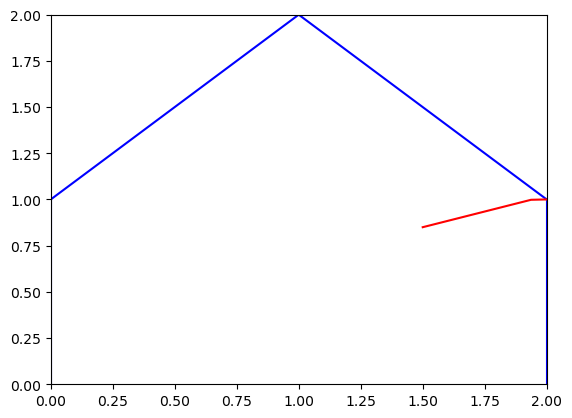

In [64]:
x0 = np.linspace(0,2,500)
x1 = np.linspace(0,2,500)

# plot boundaries of the feasible region
plt.plot(x0, 3 - x0, color='blue')
plt.plot(x0, x0+1, color='blue')
plt.plot(np.zeros(500),x1/2, color='blue')
plt.plot(2*np.ones(500),x1/2, color='blue')

plt.plot(result[:,0],result[:,1], color='red')
plt.xlim(0,2)
plt.ylim(0,2)
plt.show()

## References

Vanderbei, Robert J. *Linear Programming: Foundations and Extensions*, 5th ed. Springer, 2020.

Walls, Patrick. "Interior Point Methods". Math 441. Mathematical Modelling: Discrete Optimization Problems. 25 March 2024, University of British Columbia. Lecture.  